<a href="https://colab.research.google.com/github/brungardtdb/TFClothingClassification/blob/master/TFClothingClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U tensorflow_datasets #install datasets

    100% |████████████████████████████████| 409kB 8.1MB/s 


In [19]:
from __future__ import absolute_import, division, print_function

# Import Tensorflow and Tensorflow Datasets
import tensorflow as tf
import tensorflow_datasets as tfds
tf.logging.set_verbosity(tf.logging.ERROR)

# Helper libraries
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Improve progress bar display
import tqdm
import tqdm.auto
tqdm.tqdm = tqdm.auto.tqdm

print(tf.__version__)



1.13.1


In [0]:
# Load Fashion MNIST dataset
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

In [0]:
# Store class names into a readable string that corresponds with label image is mapped to.
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

In [22]:
# Examine dataset
num_train_examples = metadata.splits['train'].num_examples # Number of training examples
num_test_examples = metadata.splits['test'].num_examples # Number of test examples
# Print out the number of each dataset
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples: {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples: 10000


In [0]:
# Pre-Process data
def normalize(images, labels):
  images = tf.cast(images, tf.float32) # Cast pixel values to 'float' type
  images /= 255 # Normalize pixel value range to be number between 0 and 1 instead of 1 and 255
  return images, labels # Return pairs of images and labels

# The map function applies the normalize function to each element in the train and test datasets
train_dataset = train_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

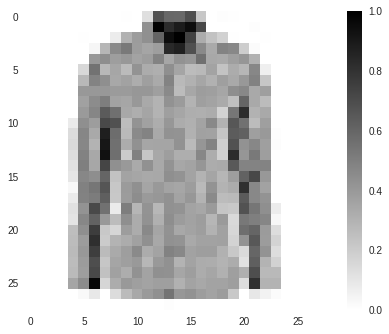

In [24]:
# Explore processed data
# Take a single image, remove color and dimension by reshaping
for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))

# Plot the image
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

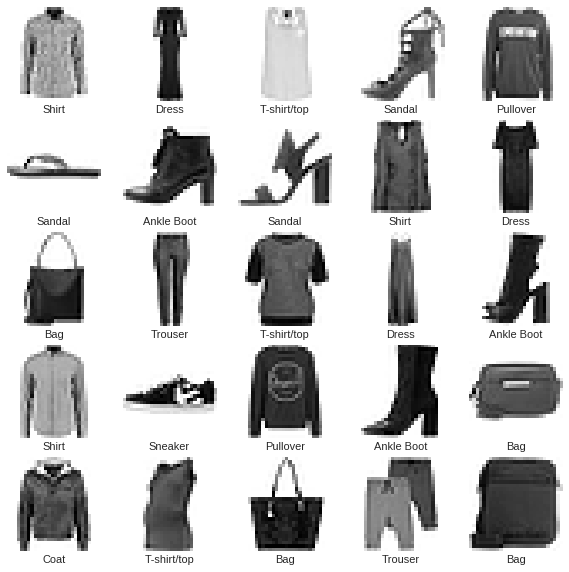

In [26]:
# Plot images for first 25 examples
plt.figure(figsize=(10,10))
i = 0
for (image, label) in test_dataset.take(25):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
    i+=1
plt.show()

In [0]:
# Build the model and set up layers
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28,1)), # Layer that transforms 2D array of pixels (28 x 28) into 1D array of pixels (28^2).
    tf.keras.layers.Dense(128, activation=tf.nn.relu), # Densely connected layer of 126 neurons. Each neuron or node takes input from all 784 nodes in previous layer, weighs output, and outputs a single value to next layer.
    tf.keras.layers.Dense(10, activation=tf.nn.softmax) # A 10-node layer, each node represents class of clothing. Each node takes input from one of the 128 previous nodes, weighs it, and outputs a value in the range of [0,1]
])                                                      # sum of all 10 nodes is 1, the number (between 0 and 1) represents the probability that the image belongs to that class.

In [0]:
# Compile the model 
model.compile(optimizer= 'adam', # Algorithm for adjusting inner parameters to minimize loss 
              loss='sparse_categorical_crossentropy', # Algorithm that measures how far model's outputs are from desired output
              metrics=['accuracy']) # Monitors training and testing steps

In [34]:
# Specify iteration parameters to dataset
BATCH_SIZE = 32
train_dataset = train_dataset.repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Train model
model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/5
1875/1875 [==============================] - 34s 18ms/step - loss: 0.4928 - acc: 0.8274
Epoch 2/5
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3758 - acc: 0.8657
Epoch 3/5
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3373 - acc: 0.8770
Epoch 4/5
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3099 - acc: 0.8867
Epoch 5/5
1875/1875 [==============================] - 20s 11ms/step - loss: 0.2908 - acc: 0.8924


In [35]:
# Evaluate accuracy
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print("Accuracy on test dataset: {}".format(test_accuracy))

313/313 [==============================] - 3s 9ms/step - loss: 0.3608 - acc: 0.8712
Accuracy on test dataset: 0.8712000250816345


In [0]:
# Make predictions
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images) # array containing predictions for test images

In [39]:
predictions.shape

(32, 10)

In [41]:
predictions[0] # Prediction for first image in dataset

array([7.9332574e-05, 1.7622165e-08, 3.0210919e-03, 1.0672561e-05,
       4.1318595e-02, 4.8085276e-08, 9.5556760e-01, 6.1595062e-09,
       2.6306250e-06, 3.5870225e-09], dtype=float32)

In [42]:
# Print which instance is the largest
np.argmax(predictions[0])

6

In [0]:
# "Fancy plots"
def plot_image(i, predictions_array, true_labels, images): 
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)
  
  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
    
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                      100*np.max(predictions_array),
                                      class_names[true_label]),
                                      color=color)

In [0]:
def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0,1])
    predicted_label = np.argmax(predictions_array)
    
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

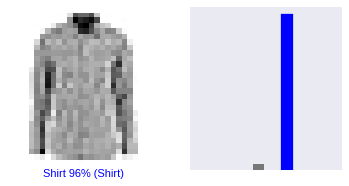

In [57]:
# First prediction
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

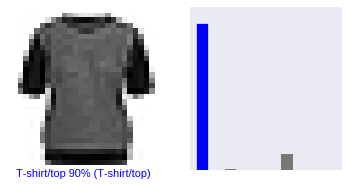

In [58]:
# First prediction
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

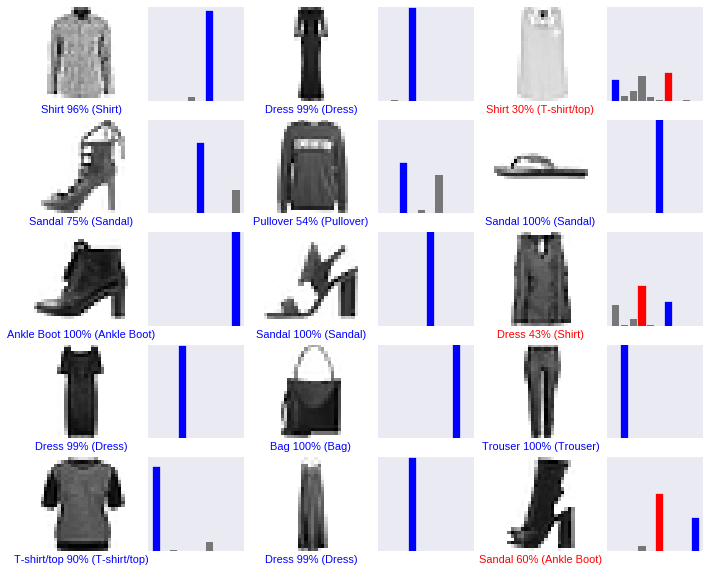

In [61]:
# Plot first X teset images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)

In [62]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

(28, 28, 1)


In [63]:
# Add the image to a batch where it's the only member.
img = np.array([img])

print(img.shape)

(1, 28, 28, 1)


In [67]:
# Predict image
predictions_single = model.predict(img)

print(predictions_single)

[[7.9332582e-05 1.7622167e-08 3.0210952e-03 1.0672572e-05 4.1318581e-02
  4.8085283e-08 9.5556772e-01 6.1595071e-09 2.6306254e-06 3.5870160e-09]]


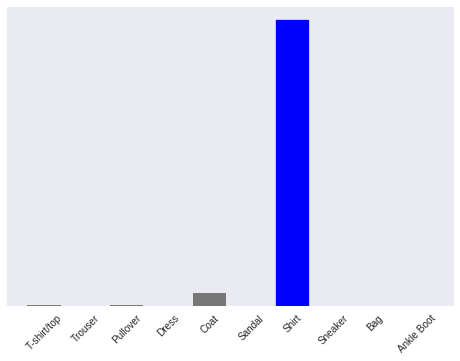

In [66]:
# Display probability distribution across classes
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

In [68]:
# Print Index
np.argmax(predictions_single[0])

6